# Image Segmentation and Feature Extraction Workflow
In this workflow, we will process a set of images and their corresponding label images to develop an image-segmentation workflow. We will then extract features from the segmented images, visualize relationships between these features, and find out which features are strongly correlated and which are not.

## Dataset Information
We are using the BBBC007v1 image set version 1 (Jones et al., Proc. ICCV Workshop on Computer Vision for Biomedical Image Applications, 2005), available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012].

## Steps to be performed
- Setup a software environment
- Setup an image processing workflow
- Develop an image segmentation workflow, including quality assessment of segmentation results
- Extract features from the segmented images
- Visualize relationships between the extracted features
- Identify correlations between the features
- Document the installation instructions, user guide, and algorithms used

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import imageio
from skimage import filters, measure, segmentation, morphology
import matplotlib.pyplot as plt
import seaborn as sns
import stackview
from the_segmentation_game import metrics

### Installation Instructions
1. Install Python 3.x
2. Install the required libraries:
```bash
pip install numpy pandas imageio scikit-image matplotlib seaborn stackview
```
3. Ensure the dataset is available in the correct directories as specified in the notebook.

### Load images and corresponding label images
We will load all the images and their corresponding label images from the specified folders.

In [2]:
image_folder = '../05b_quality_assurance/data/BBBC007_batch/'
label_folder = '../05b_quality_assurance/data/BBBC007_sparse_instance_annotation/'

image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.tif')])
label_files = sorted([os.path.join(label_folder, f) for f in os.listdir(label_folder) if f.endswith('.tif')])

images = [imageio.imread(os.path.join(image_folder, f)) for f in os.listdir(image_folder) if f.endswith('.tif')]
labels = [imageio.imread(os.path.join(label_folder, f)) for f in os.listdir(label_folder) if f.endswith('.tif')]

print(f'Total images loaded: {len(images)}')
print(f'Total label images loaded: {len(labels)}')

Total images loaded: 6
Total label images loaded: 6


C:\Users\haase\AppData\Local\Temp\ipykernel_4356\1134600112.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(image_folder, f)) for f in os.listdir(image_folder) if f.endswith('.tif')]
C:\Users\haase\AppData\Local\Temp\ipykernel_4356\1134600112.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  labels = [imageio.imread(os.path.join(label_folder, f)) for f in os.listdir(label_folder) if f.endswith('.tif')]


### Perform image segmentation
We will perform simple segmentation using thresholding followed by morphological operations. The segmentation results will be evaluated against the provided label images using the sparse Jaccard index.

Segmentation completed.
Mean Jaccard Index: 0.5311484310630238


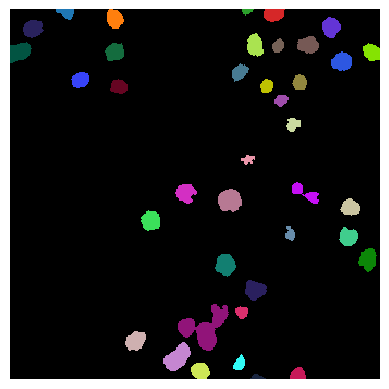

In [3]:
segmented_images = []
jaccard_indexes = []

for image, reference_labels in zip(images, labels):
    # Apply thresholding
    thresh = filters.threshold_otsu(image)
    binary = image > thresh
    
    # Morphological operations to remove small objects and fill holes
    cleaned = morphology.remove_small_objects(binary, 30)
    cleaned = morphology.remove_small_holes(cleaned, 30)
    
    # Label connected components
    label_image = measure.label(cleaned)
    segmented_images.append(label_image)
    
    # Measure segmentation quality using sparse Jaccard index
    jaccard_index = metrics.jaccard_index_sparse(reference_labels, label_image)
    jaccard_indexes.append(jaccard_index)
    
print('Segmentation completed.')
print(f'Mean Jaccard Index: {np.mean(jaccard_indexes)}')

# Display an example segmented image
stackview.imshow(segmented_images[0])

### Extract features from segmented images
We will extract features such as area, perimeter, and mean intensity from each of the segmented objects in the images.

In [4]:
features = []

for img, labels in zip(images, segmented_images):
    props = measure.regionprops(labels, intensity_image=img)
    for prop in props:
        features.append({
            'label': prop.label,
            'area': prop.area,
            'perimeter': prop.perimeter,
            'mean_intensity': prop.mean_intensity
        })

features_df = pd.DataFrame(features)
display(features_df)

,label,area,perimeter,mean_intensity
0,1,114.0,44.142136,106.385965
1,2,218.0,54.041631,95.871560
2,3,45.0,25.278175,94.400000
3,4,194.0,53.349242,100.757732
4,5,248.0,57.112698,107.237903
...,...,...,...,...
276,16,179.0,54.284271,89.134078
277,17,166.0,52.213203,84.722892
278,18,5725.0,426.558441,128.485939
279,19,59.0,27.313708,76.237288


### Visualize relationships between extracted features
We will create pair plots and correlation matrices to explore relationships between the extracted features.

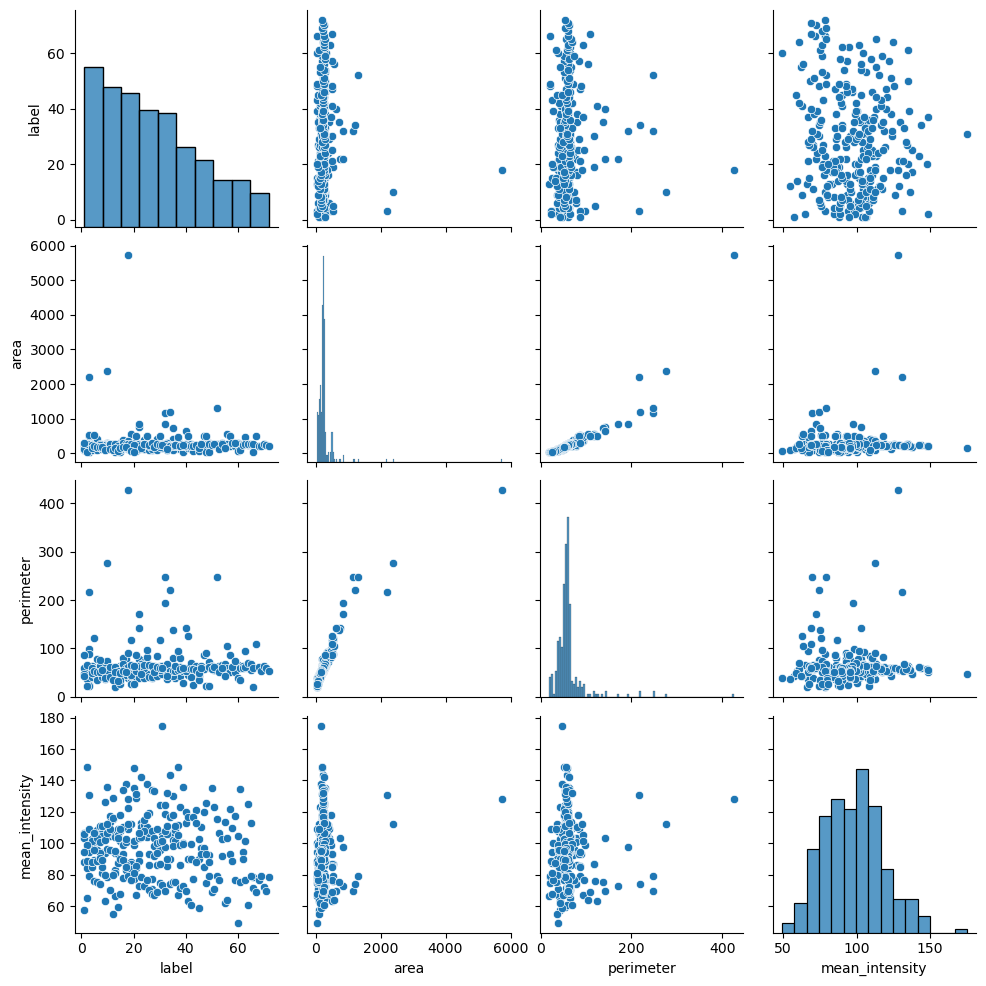

In [5]:
# Pair plot of features
sns.pairplot(features_df)
plt.show()

### Identify correlations between features
We will calculate the correlation coefficients between the features and visualize them using a heatmap.

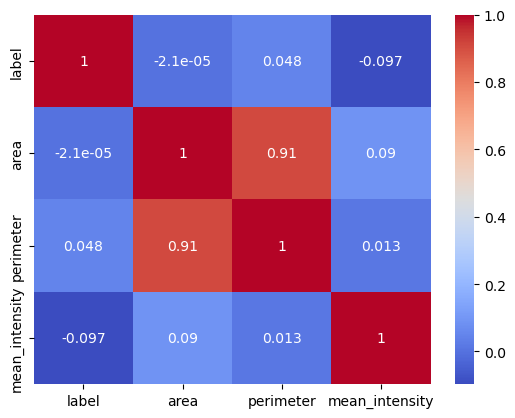

Correlation matrix:


,label,area,perimeter,mean_intensity
label,1.000000,-0.000021,0.048233,-0.096897
area,-0.000021,1.000000,0.907471,0.089972
perimeter,0.048233,0.907471,1.000000,0.013228
mean_intensity,-0.096897,0.089972,0.013228,1.000000


In [6]:
# Compute correlation matrix
correlation_matrix = features_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()
print('Correlation matrix:')
display(correlation_matrix)

### Save results to disk
We will save the segmented images and the feature extraction results to disk.

In [7]:
# Save segmented images
segmented_output_folder = '../05b_quality_assurance/data/segmented_images/'
os.makedirs(segmented_output_folder, exist_ok=True)

for i, segmented_image in enumerate(segmented_images):
    output_path = os.path.join(segmented_output_folder, f'segmented_{i}.tif')
    imageio.imwrite(output_path, segmented_image)

# Save features to CSV
features_df.to_csv('../05b_quality_assurance/data/extracted_features.csv', index=False)
print('Segmented images and features saved to disk.')

Segmented images and features saved to disk.


## Documentation

### Installation Instructions
1. Install Python 3.x
2. Install the required libraries:
```bash
pip install numpy pandas imageio scikit-image matplotlib seaborn stackview
```
3. Ensure the dataset is available in the correct directories as specified in the notebook.

### User Guide
1. Follow the steps in the notebook to load images and perform segmentation.
2. Use the extracted features for further analysis or visualization.
3. Check the `segmented_images` folder for segmented output images.
4. The features extracted are saved in `extracted_features.csv`.

### Documentation of Used Data
We used the BBBC007v1 image set version 1 (Jones et al., Proc. ICCV Workshop on Computer Vision for Biomedical Image Applications, 2005), available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012].

### Explanation of Used Algorithms
1. **Otsu's Thresholding**: This method automatically determines the threshold value from the image histogram to binarize the image.
2. **Morphological Operations**: These are used to clean up the binary images by removing small objects and filling holes.
3. **Regionprops**: This function from `scikit-image` is used to measure properties of labeled image regions, such as area, perimeter, and mean intensity.